# Predicting Stock Price Using Regression Models and ARIMA

**Problem Statement**

The dataset uploaded contains historical stock prices that span to a total instances of 1,140 (days) of 17 peer companies and 6 indexes. Based on the dataset, the stock price of the target company, 'MMAX', is to be predicted for the 1,141th day.

Code reference: https://github.com/tatsath/fin-ml

In [5]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from pandas.plotting import scatter_matrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import optuna

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Cleaning and Engineering

In [6]:
df = pd.read_csv("Stock_prices.csv")

In [8]:
df.head()

Date       MMAX       AAPL       AMZN       GOOGL         MCD         GM  \
0     1  33.482319  34.465744  50.064999  976.619995  137.422821  30.548828   
1     2  34.008343  34.619576  50.187000  986.090027  137.280762  30.557764   
2     3  33.785179  34.510723  49.699001  972.090027  136.677109  30.843687   
3     4  31.489800  34.016071  48.839001  948.090027  136.464066  30.566696   
4     5  32.023800  34.513088  49.516499  961.010010  136.978943  30.897297   

        TSLA        PFE       SBUX  ...        HST        HLT         FDX  \
0  76.522003  26.870838  53.836395  ...  16.140646  63.823997  199.325455   
1  76.690002  26.957619  54.107803  ...  16.183868  64.019783  202.829193   
2  75.498001  26.855061  53.954002  ...  16.382711  63.853378  202.838623   
3  72.473999  26.642052  53.338821  ...  16.261677  62.110935  201.868484   
4  74.248001  26.626272  53.537861  ...  16.252941  62.022831  204.524536   

          DPZ    SP500      DJIA  VIXCLS  DEXJPUS  DEXUSUK  DEXUSEU  
0  208.325409  2434.50  21397.29   10.48   111.36   1.2659   1.1148  
1  207.332001  2438.30  21394.76   10.02   111.26   1.2727   1.1196  
2  209.080063  2439.07  21409.55    9.90   111.48   1.2732   1.1196  
3  203.597061  2419.38  21310.66   11.06   112.42   1.2791   1.1300  
4  204.036484  2440.69  21454.61   10.03   112.18   1.2936   1.1364  

[5 rows x 25 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1141 non-null   int64  
 1   MMAX     1140 non-null   float64
 2   AAPL     1141 non-null   float64
 3   AMZN     1141 non-null   float64
 4   GOOGL    1141 non-null   float64
 5   MCD      1141 non-null   float64
 6   GM       1141 non-null   float64
 7   TSLA     1141 non-null   float64
 8   PFE      1141 non-null   float64
 9   SBUX     1141 non-null   float64
 10  TWTR     1141 non-null   float64
 11  VZ       1141 non-null   float64
 12  WYNN     1141 non-null   float64
 13  KHC      1141 non-null   float64
 14  JNJ      1141 non-null   float64
 15  HST      1141 non-null   float64
 16  HLT      1141 non-null   float64
 17  FDX      1141 non-null   float64
 18  DPZ      1141 non-null   float64
 19  SP500    1141 non-null   float64
 20  DJIA     1141 non-null   float64
 21  VIXCLS   1141 

In [10]:
#Plotting historical prices of MMAX

MMAX=df['MMAX']

trend=MMAX.pct_change().dropna()

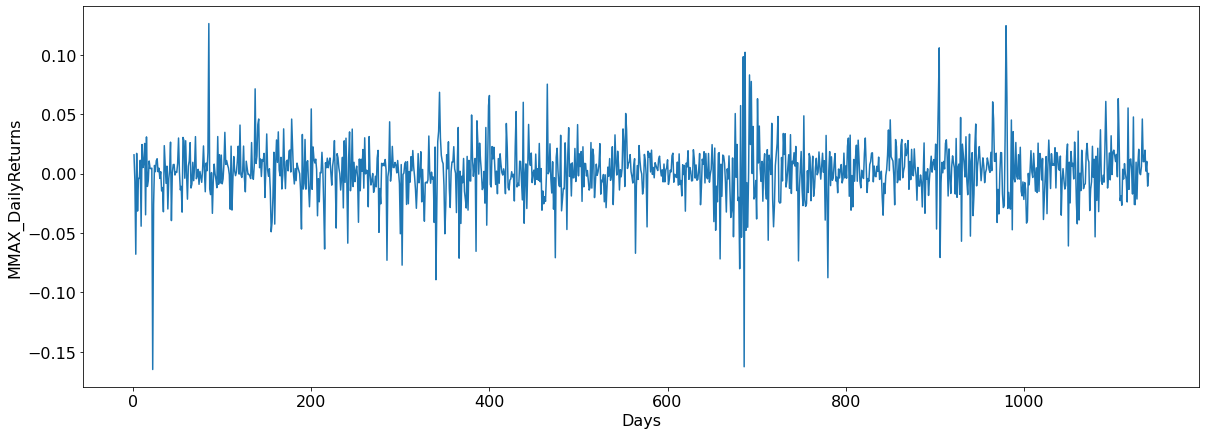

In [12]:
trend.plot(figsize=(20,7), fontsize = 16)
plt.xlabel('Days',fontsize = 16)
plt.ylabel('MMAX_DailyReturns',fontsize = 16)
plt.show();

In [14]:
#Checking for blanks and null values
#There is one NaN value in the dataset which is the target price to be predicted for MMAX

df = df.replace(' ', np.nan)

df.isna().sum()

Date       0
MMAX       1
AAPL       0
AMZN       0
GOOGL      0
MCD        0
GM         0
TSLA       0
PFE        0
SBUX       0
TWTR       0
VZ         0
WYNN       0
KHC        0
JNJ        0
HST        0
HLT        0
FDX        0
DPZ        0
SP500      0
DJIA       0
VIXCLS     0
DEXJPUS    0
DEXUSUK    0
DEXUSEU    0
dtype: int64

In [15]:
#checking for zero values
#3 indexes contain zero (missing) values

df.eq(0).any()

Date       False
MMAX       False
AAPL       False
AMZN       False
GOOGL      False
MCD        False
GM         False
TSLA       False
PFE        False
SBUX       False
TWTR       False
VZ         False
WYNN       False
KHC        False
JNJ        False
HST        False
HLT        False
FDX        False
DPZ        False
SP500      False
DJIA       False
VIXCLS     False
DEXJPUS     True
DEXUSUK     True
DEXUSEU     True
dtype: bool

In [16]:
#imputing 0 values in DEXJPUS, DEXUSUK, DEXUSEU with the respective exchange rate of the preceding day 
#for each of the three features as exchange rates cannot be 0

df['DEXJPUS'].replace(to_replace = 0,  method='ffill', inplace=True)
df['DEXUSUK'].replace(to_replace = 0,  method='ffill', inplace=True)
df['DEXUSEU'].replace(to_replace = 0,  method='ffill', inplace=True)

In [17]:
#calculating log returns (against a return period of 5 days) of the dependant variable Y (MMAX stock prices)
#and shifting calculated returns back by 5 instances (or days)

return_period = 5
Y = np.log(df.loc[:,'MMAX']).diff(return_period).shift(-return_period)
Y.name = 'MMAX_pred'
Y.head(10)
Y.tail(10)

0   -0.076656
1   -0.096365
2   -0.093919
3   -0.012480
4   -0.074644
5   -0.018416
6   -0.009334
7    0.003363
8    0.017277
9    0.027247
Name: MMAX_pred, dtype: float64

1131    0.090169
1132    0.086277
1133    0.051568
1134    0.030972
1135         NaN
1136         NaN
1137         NaN
1138         NaN
1139         NaN
1140         NaN
Name: MMAX_pred, dtype: float64

In [18]:
#transforming stock prices and rates of peer companies into log returns (return period = 5 days) and 
#adding 4 new features [1W,2W,3W,4W] that represent 1 week, 2 weeks, 3, weeks and 4 weeks moving averages
#of log returns of the MMAX stock

X1 = np.log(df.loc[:, df.columns.values[2:]]).diff(return_period)
X1.columns = df.columns.values[2:]

X2 = pd.concat([np.log(df.loc[:, ('MMAX')]).diff(i) for i in [5, 10, 15,20]], axis=1)
X2.columns = ['1W', '2W', '3W', '4W']

X = pd.concat([X1, X2], axis=1)

dataset = pd.concat([Y, X], axis=1)
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

dataset.head(10)
dataset.tail(10)

MMAX_pred      AAPL      AMZN     GOOGL       MCD        GM      TSLA  \
0  -0.076656       NaN       NaN       NaN       NaN       NaN       NaN   
1  -0.096365       NaN       NaN       NaN       NaN       NaN       NaN   
2  -0.093919       NaN       NaN       NaN       NaN       NaN       NaN   
3  -0.012480       NaN       NaN       NaN       NaN       NaN       NaN   
4  -0.074644       NaN       NaN       NaN       NaN       NaN       NaN   
5  -0.018416 -0.013481 -0.025664 -0.040540 -0.010847  0.019407 -0.058831   
6  -0.009334 -0.015570 -0.036256 -0.058907 -0.009616  0.021120 -0.058643   
7   0.003363 -0.016038 -0.041410 -0.055662 -0.009528  0.029964 -0.068153   
8   0.017277  0.002502 -0.005523 -0.016838 -0.004238  0.023116 -0.102430   
9   0.027247 -0.021487 -0.025765 -0.035287 -0.007873  0.008351 -0.184058   

        PFE      SBUX      TWTR  ...     SP500      DJIA    VIXCLS   DEXJPUS  \
0       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
5 -0.012705 -0.019514 -0.027935  ... -0.006098 -0.005166  0.087647  0.008584   
6 -0.017120 -0.025399 -0.034647  ... -0.006125 -0.002112  0.109543  0.010194   
7 -0.006484 -0.023582 -0.035619  ... -0.004133  0.003251  0.125163  0.016370   
8 -0.003857 -0.017451 -0.016695  ...  0.005425  0.007830  0.000904  0.006914   
9 -0.015828 -0.027061 -0.001673  ... -0.012758 -0.006292  0.223343  0.009758   

    DEXUSUK   DEXUSEU        1W  2W  3W  4W  
0       NaN       NaN       NaN NaN NaN NaN  
1       NaN       NaN       NaN NaN NaN NaN  
2       NaN       NaN       NaN NaN NaN NaN  
3       NaN       NaN       NaN NaN NaN NaN  
4       NaN       NaN       NaN NaN NaN NaN  
5  0.025349  0.024106 -0.076656 NaN NaN NaN  
6  0.020839  0.019021 -0.096365 NaN NaN NaN  
7  0.017054  0.015158 -0.093919 NaN NaN NaN  
8  0.011118  0.003181 -0.012480 NaN NaN NaN  
9  0.002394  0.003952 -0.074644 NaN NaN NaN  

[10 rows x 28 columns]

MMAX_pred      AAPL      AMZN     GOOGL       MCD        GM      TSLA  \
1131   0.090169 -0.047415 -0.012825 -0.043334 -0.012418 -0.136224 -0.086698   
1132   0.086277 -0.034679 -0.014784 -0.029362 -0.005183 -0.090014 -0.071260   
1133   0.051568 -0.007716  0.007808 -0.003024  0.007098 -0.063808 -0.021065   
1134   0.030972 -0.020624 -0.013231 -0.000178  0.001586 -0.044126  0.033134   
1135        NaN  0.023069  0.012929  0.016966  0.001505 -0.025674  0.140739   
1136        NaN  0.052307 -0.002049  0.042692  0.024683  0.040329  0.159597   
1137        NaN  0.054678  0.021212  0.035245  0.023226  0.055255  0.190200   
1138        NaN  0.036273 -0.007161  0.021940  0.015388  0.043571  0.146117   
1139        NaN  0.014470 -0.014087 -0.001466  0.008531  0.035903  0.059145   
1140        NaN  0.007291 -0.025766 -0.014152  0.007940  0.029775 -0.009624   

           PFE      SBUX      TWTR  ...     SP500      DJIA    VIXCLS  \
1131  0.119508 -0.071916 -0.056203  ... -0.019583 -0.016978  0.143315   
1132  0.100239 -0.066826 -0.036999  ... -0.021859 -0.020368  0.118713   
1133  0.059586 -0.038569  0.000226  ...  0.003262 -0.001449 -0.041031   
1134  0.012674 -0.025971 -0.003865  ... -0.002826 -0.004842 -0.034814   
1135 -0.042354 -0.010798  0.023601  ...  0.012161  0.001473 -0.135687   
1136 -0.004719  0.050179  0.028835  ...  0.036246  0.026148 -0.198869   
1137 -0.050586  0.066912  0.010416  ...  0.046688  0.041112 -0.265342   
1138 -0.023514  0.053022 -0.036735  ...  0.030467  0.027674 -0.214731   
1139 -0.019500  0.039482  0.012676  ...  0.017344  0.017857 -0.072334   
1140  0.005774  0.040120 -0.021516  ...  0.008510  0.010728 -0.042076   

       DEXJPUS   DEXUSUK   DEXUSEU        1W        2W        3W        4W  
1131  0.001763  0.000528 -0.003099  0.005758 -0.008575  0.058009  0.031690  
1132  0.000264 -0.000832  0.000000  0.033367  0.014757  0.010230  0.042258  
1133  0.004215  0.002115  0.000444  0.070768  0.013110  0.068525  0.078804  
1134  0.003420  0.009865  0.005579  0.060501  0.049370  0.067124  0.089129  
1135  0.006576  0.006359  0.000972  0.069748  0.085938  0.064980  0.104471  
1136  0.011296  0.012656  0.004601  0.090169  0.095927  0.081595  0.148178  
1137  0.011394  0.015758  0.001415  0.086277  0.119644  0.101034  0.096507  
1138  0.007508  0.016612  0.005750  0.051568  0.122336  0.064678  0.120093  
1139  0.008283  0.011548 -0.000530  0.030972  0.091473  0.080343  0.098096  
1140  0.006533  0.006689 -0.000177       NaN       NaN       NaN       NaN  

[10 rows x 28 columns]

In [19]:
#saving X features values of the 1,140th day that will be later used to predict the missing stock price of MMAX

Xfeatures=dataset.iloc[1139,1:]
Xfeatures

AAPL       0.014470
AMZN      -0.014087
GOOGL     -0.001466
MCD        0.008531
GM         0.035903
TSLA       0.059145
PFE       -0.019500
SBUX       0.039482
TWTR       0.012676
VZ        -0.009903
WYNN       0.003255
KHC        0.015544
JNJ        0.025748
HST        0.019563
HLT        0.014559
FDX        0.033827
DPZ        0.041352
SP500      0.017344
DJIA       0.017857
VIXCLS    -0.072334
DEXJPUS    0.008283
DEXUSUK    0.011548
DEXUSEU   -0.000530
1W         0.030972
2W         0.091473
3W         0.080343
4W         0.098096
Name: 1139, dtype: float64

In [20]:
#dropping rows to remove instances with NaN values

dataset.dropna(inplace=True)
dataset.shape
dataset

(1115, 28)

MMAX_pred      AAPL      AMZN     GOOGL       MCD        GM      TSLA  \
20    -0.193705  0.008219  0.023538  0.017182 -0.008797 -0.007733  0.001890   
21    -0.187567  0.016775  0.028221  0.022642 -0.022208 -0.015513  0.069354   
22     0.005107  0.017569  0.014940 -0.018324  0.032652 -0.023890  0.034023   
23     0.032850  0.016028  0.024938 -0.028050  0.016882 -0.023583  0.055581   
24     0.030548  0.001462  0.016677 -0.040814  0.017612 -0.012993  0.013667   
...         ...       ...       ...       ...       ...       ...       ...   
1130   0.069748 -0.013264 -0.030902 -0.021868  0.012162 -0.020846 -0.079681   
1131   0.090169 -0.047415 -0.012825 -0.043334 -0.012418 -0.136224 -0.086698   
1132   0.086277 -0.034679 -0.014784 -0.029362 -0.005183 -0.090014 -0.071260   
1133   0.051568 -0.007716  0.007808 -0.003024  0.007098 -0.063808 -0.021065   
1134   0.030972 -0.020624 -0.013231 -0.000178  0.001586 -0.044126  0.033134   

           PFE      SBUX      TWTR  ...     SP500      DJIA    VIXCLS  \
20    0.001494 -0.013363  0.023649  ...  0.005381 -0.002669 -0.015899   
21    0.002103 -0.005329  0.003004  ...  0.004370 -0.005403 -0.040525   
22   -0.007824  0.005824 -0.000501  ...  0.006691  0.001792 -0.047628   
23   -0.021952 -0.002930 -0.025675  ...  0.001616  0.003241 -0.019598   
24   -0.016231  0.025016 -0.198130  ...  0.000796  0.008513  0.053847   
...        ...       ...       ...  ...       ...       ...       ...   
1130  0.162183 -0.015375 -0.074373  ...  0.000261  0.003990 -0.047933   
1131  0.119508 -0.071916 -0.056203  ... -0.019583 -0.016978  0.143315   
1132  0.100239 -0.066826 -0.036999  ... -0.021859 -0.020368  0.118713   
1133  0.059586 -0.038569  0.000226  ...  0.003262 -0.001449 -0.041031   
1134  0.012674 -0.025971 -0.003865  ... -0.002826 -0.004842 -0.034814   

       DEXJPUS   DEXUSUK   DEXUSEU        1W        2W        3W        4W  
20   -0.013224 -0.008523  0.017571  0.002024  0.035489  0.017073 -0.059583  
21   -0.014831 -0.002300  0.014884  0.017506  0.035064  0.025730 -0.070635  
22   -0.002864  0.001534  0.006714 -0.156643 -0.153807 -0.150444 -0.244363  
23    0.002948  0.000920  0.009849 -0.193392 -0.205047 -0.187769 -0.200249  
24   -0.000537  0.006835  0.001889 -0.191189 -0.162887 -0.135641 -0.210285  
...        ...       ...       ...       ...       ...       ...       ...  
1130  0.001232  0.010335  0.002124  0.016190 -0.004768  0.034723  0.036208  
1131  0.001763  0.000528 -0.003099  0.005758 -0.008575  0.058009  0.031690  
1132  0.000264 -0.000832  0.000000  0.033367  0.014757  0.010230  0.042258  
1133  0.004215  0.002115  0.000444  0.070768  0.013110  0.068525  0.078804  
1134  0.003420  0.009865  0.005579  0.060501  0.049370  0.067124  0.089129  

[1115 rows x 28 columns]

## Converting the data to supervised regression format

In [22]:
#Adjusting all X features to lag by one day so that the data of the (n-1)st day can be used to predict
#the stock price of MMAX on the nth day

def series_to_supervised(data, lag=1):
    n_vars = data.shape[1]
    df1 = pd.DataFrame(data)    
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df1.shift(i))
        names += [('%s(t-%d)' % (df1.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    agg.dropna(inplace=True)
    return agg

In [23]:
dataset= series_to_supervised(dataset,1)
dataset.head(5)

MMAX_pred  MMAX_pred(t-1)  AAPL(t-1)  AMZN(t-1)  GOOGL(t-1)  MCD(t-1)  \
21  -0.187567       -0.193705   0.008219   0.023538    0.017182 -0.008797   
22   0.005107       -0.187567   0.016775   0.028221    0.022642 -0.022208   
23   0.032850        0.005107   0.017569   0.014940   -0.018324  0.032652   
24   0.030548        0.032850   0.016028   0.024938   -0.028050  0.016882   
25   0.024835        0.030548   0.001462   0.016677   -0.040814  0.017612   

     GM(t-1)  TSLA(t-1)  PFE(t-1)  SBUX(t-1)  ...  SP500(t-1)  DJIA(t-1)  \
21 -0.007733   0.001890  0.001494  -0.013363  ...    0.005381  -0.002669   
22 -0.015513   0.069354  0.002103  -0.005329  ...    0.004370  -0.005403   
23 -0.023890   0.034023 -0.007824   0.005824  ...    0.006691   0.001792   
24 -0.023583   0.055581 -0.021952  -0.002930  ...    0.001616   0.003241   
25 -0.012993   0.013667 -0.016231   0.025016  ...    0.000796   0.008513   

    VIXCLS(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  DEXUSEU(t-1)   1W(t-1)   2W(t-1)  \
21    -0.015899     -0.013224     -0.008523      0.017571  0.002024  0.035489   
22    -0.040525     -0.014831     -0.002300      0.014884  0.017506  0.035064   
23    -0.047628     -0.002864      0.001534      0.006714 -0.156643 -0.153807   
24    -0.019598      0.002948      0.000920      0.009849 -0.193392 -0.205047   
25     0.053847     -0.000537      0.006835      0.001889 -0.191189 -0.162887   

     3W(t-1)   4W(t-1)  
21  0.017073 -0.059583  
22  0.025730 -0.070635  
23 -0.150444 -0.244363  
24 -0.187769 -0.200249  
25 -0.135641 -0.210285  

[5 rows x 29 columns]

## Exploratory Data Analysis

In [24]:
dataset.dtypes

MMAX_pred         float64
MMAX_pred(t-1)    float64
AAPL(t-1)         float64
AMZN(t-1)         float64
GOOGL(t-1)        float64
MCD(t-1)          float64
GM(t-1)           float64
TSLA(t-1)         float64
PFE(t-1)          float64
SBUX(t-1)         float64
TWTR(t-1)         float64
VZ(t-1)           float64
WYNN(t-1)         float64
KHC(t-1)          float64
JNJ(t-1)          float64
HST(t-1)          float64
HLT(t-1)          float64
FDX(t-1)          float64
DPZ(t-1)          float64
SP500(t-1)        float64
DJIA(t-1)         float64
VIXCLS(t-1)       float64
DEXJPUS(t-1)      float64
DEXUSUK(t-1)      float64
DEXUSEU(t-1)      float64
1W(t-1)           float64
2W(t-1)           float64
3W(t-1)           float64
4W(t-1)           float64
dtype: object

In [25]:
dataset.describe()

MMAX_pred  MMAX_pred(t-1)    AAPL(t-1)    AMZN(t-1)   GOOGL(t-1)  \
count  1114.000000     1114.000000  1114.000000  1114.000000  1114.000000   
mean      0.006398        0.006197     0.007097     0.005409     0.004801   
std       0.049165        0.049523     0.040281     0.040719     0.035490   
min      -0.187567       -0.193705    -0.192744    -0.150770    -0.167899   
25%      -0.021477       -0.021690    -0.014232    -0.017365    -0.013455   
50%       0.008456        0.008352     0.010496     0.006031     0.007182   
75%       0.033577        0.033577     0.029388     0.028383     0.024851   
max       0.217295        0.217295     0.169017     0.164456     0.144602   

          MCD(t-1)      GM(t-1)    TSLA(t-1)     PFE(t-1)    SBUX(t-1)  ...  \
count  1114.000000  1114.000000  1114.000000  1114.000000  1114.000000  ...   
mean      0.002882     0.002451     0.011948     0.003609     0.003288  ...   
std       0.031139     0.056715     0.090281     0.033618     0.036595  ...   
min      -0.315603    -0.436718    -0.562924    -0.166541    -0.238555  ...   
25%      -0.009880    -0.025754    -0.037925    -0.011610    -0.013239  ...   
50%       0.005215     0.000655     0.010264     0.004741     0.005272  ...   
75%       0.016910     0.029707     0.055562     0.021263     0.021435  ...   
max       0.204027     0.279679     0.447730     0.162183     0.182321  ...   

        SP500(t-1)    DJIA(t-1)  VIXCLS(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  \
count  1114.000000  1114.000000  1114.000000   1114.000000   1114.000000   
mean      0.002841     0.002229     0.003465      0.000063      0.000076   
std       0.025266     0.027233     0.172343      0.009460      0.012860   
min      -0.198044    -0.208720    -0.559093     -0.052258     -0.091515   
25%      -0.005551    -0.007076    -0.092363     -0.005170     -0.007021   
50%       0.005413     0.004420    -0.012569      0.000606     -0.000480   
75%       0.015109     0.014431     0.079174      0.005729      0.007877   
max       0.160395     0.183091     0.991966      0.052731      0.075400   

       DEXUSEU(t-1)      1W(t-1)      2W(t-1)      3W(t-1)      4W(t-1)  
count   1114.000000  1114.000000  1114.000000  1114.000000  1114.000000  
mean      -0.000097     0.005407     0.010774     0.016243     0.021234  
std        0.009189     0.050264     0.068079     0.082789     0.096781  
min       -0.040434    -0.193705    -0.206556    -0.239173    -0.282760  
25%       -0.006072    -0.022547    -0.030446    -0.036392    -0.041329  
50%        0.000042     0.008028     0.013256     0.021431     0.021955  
75%        0.005694     0.033389     0.053894     0.065588     0.079802  
max        0.034684     0.217295     0.213503     0.256242     0.276644  

[8 rows x 29 columns]

In [26]:
#No use of lagged variable of MMAX_pred
dataset.drop(columns=['MMAX_pred(t-1)'], inplace=True)

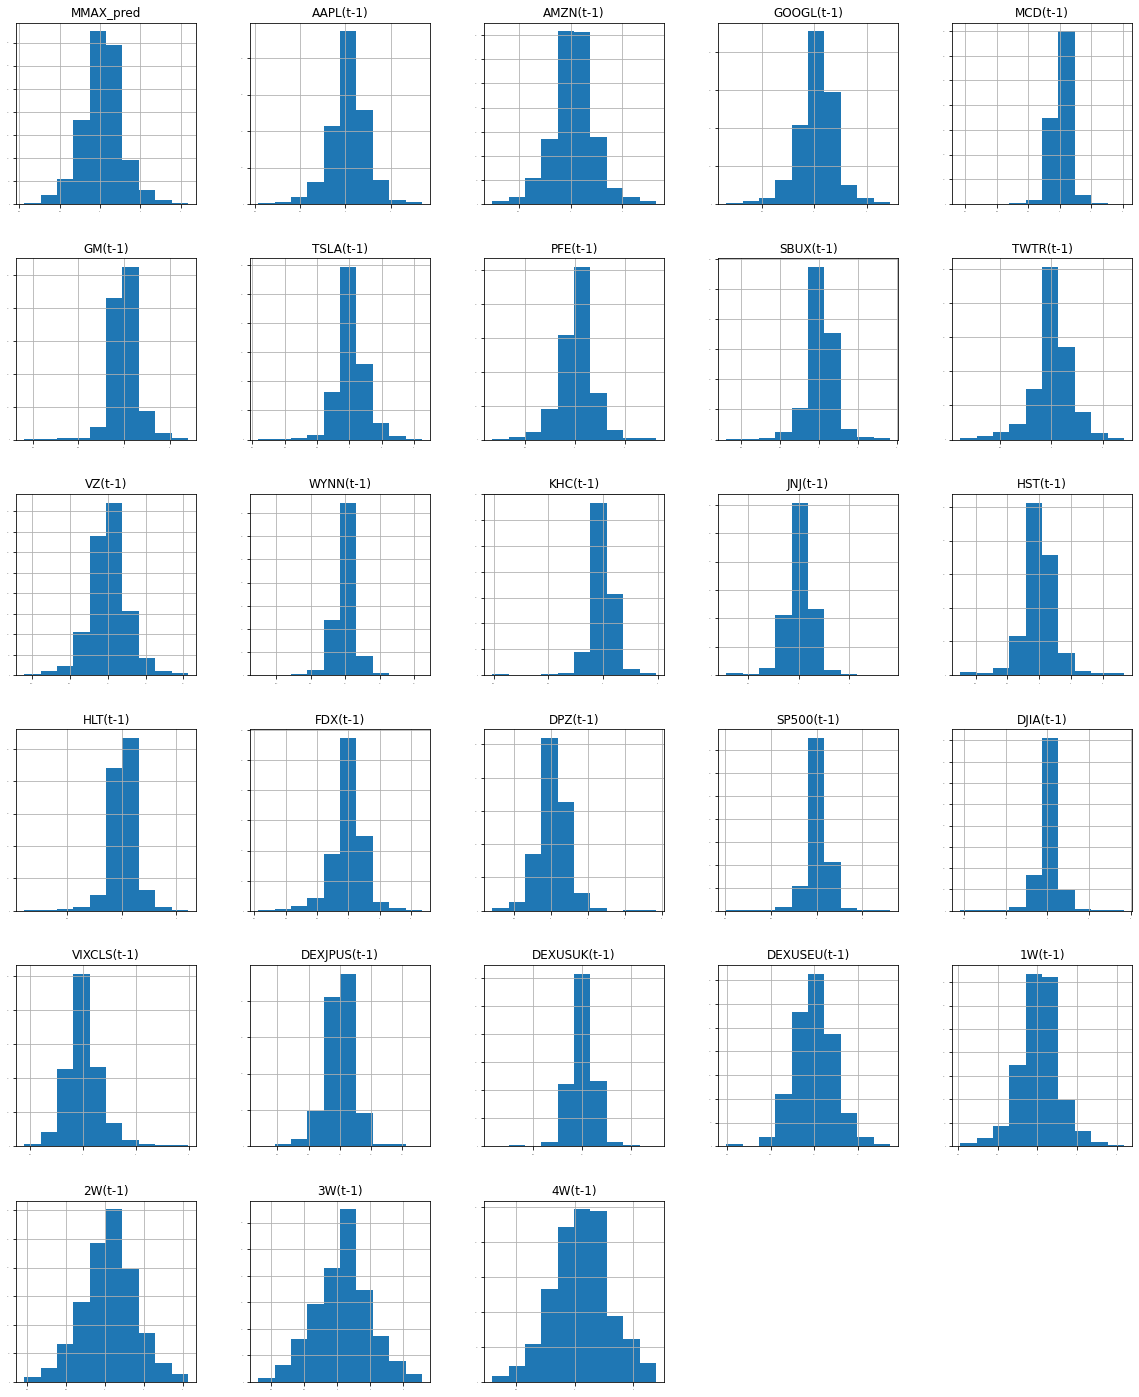

In [27]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(20,25))
plt.show();

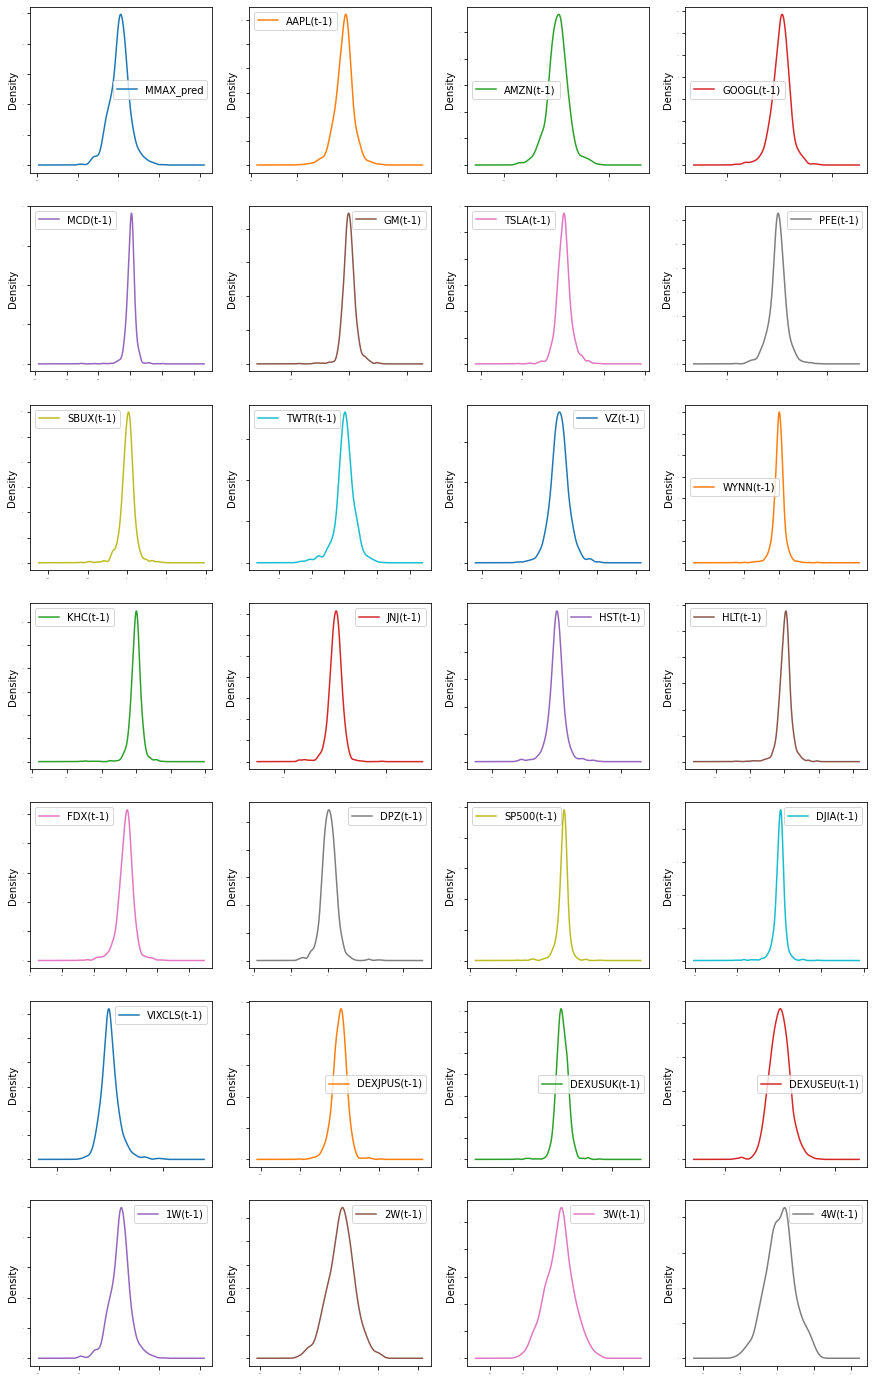

In [28]:
dataset.plot(kind='density', subplots=True, layout=(7,4), sharex=False, legend=True, fontsize=1, figsize=(15,25))
plt.show();

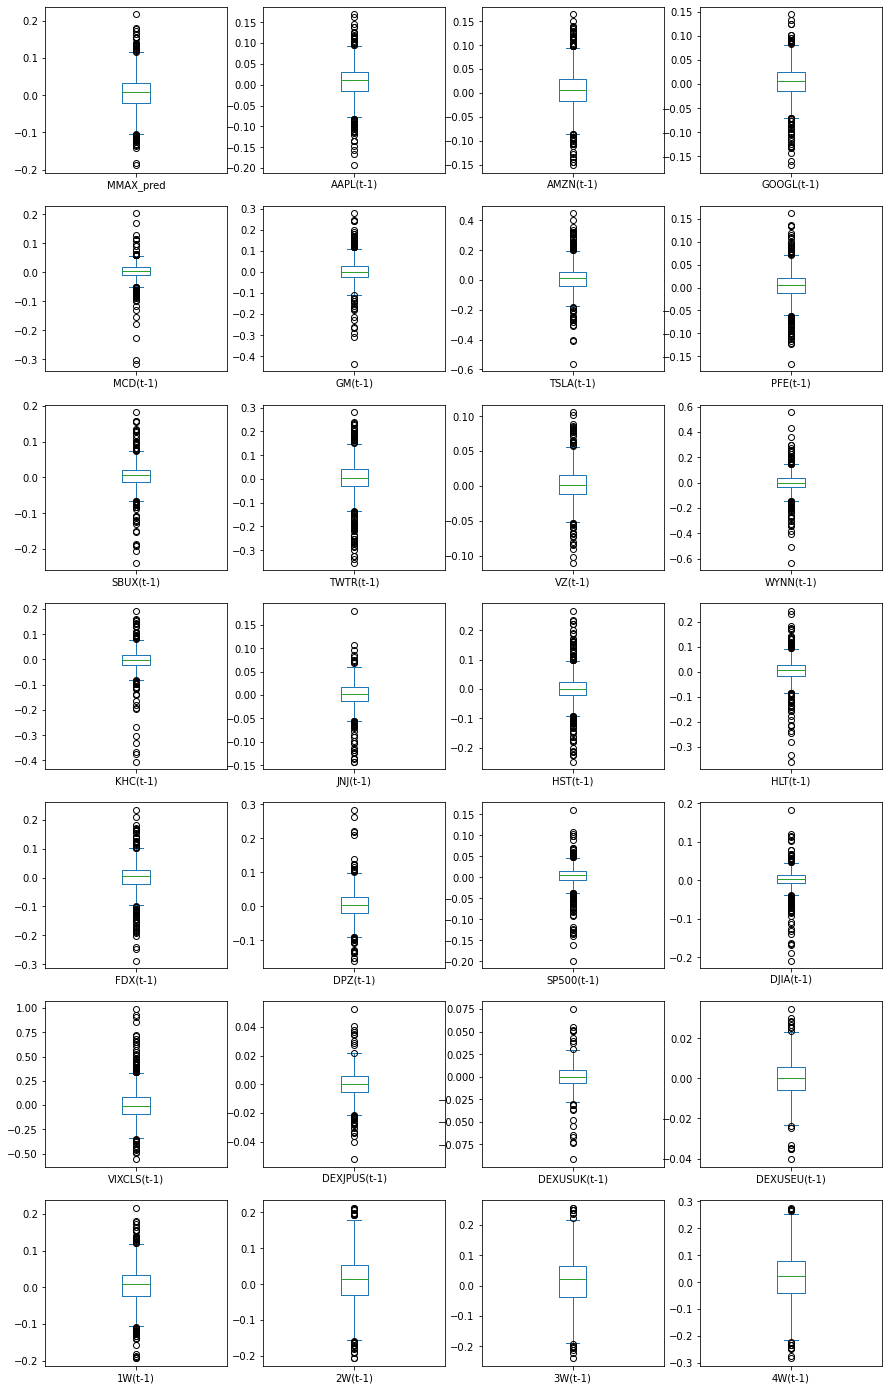

In [29]:
dataset.plot(kind='box', subplots=True, layout=(7,4), sharex=False, sharey=False, figsize=(15,25))
plt.show();

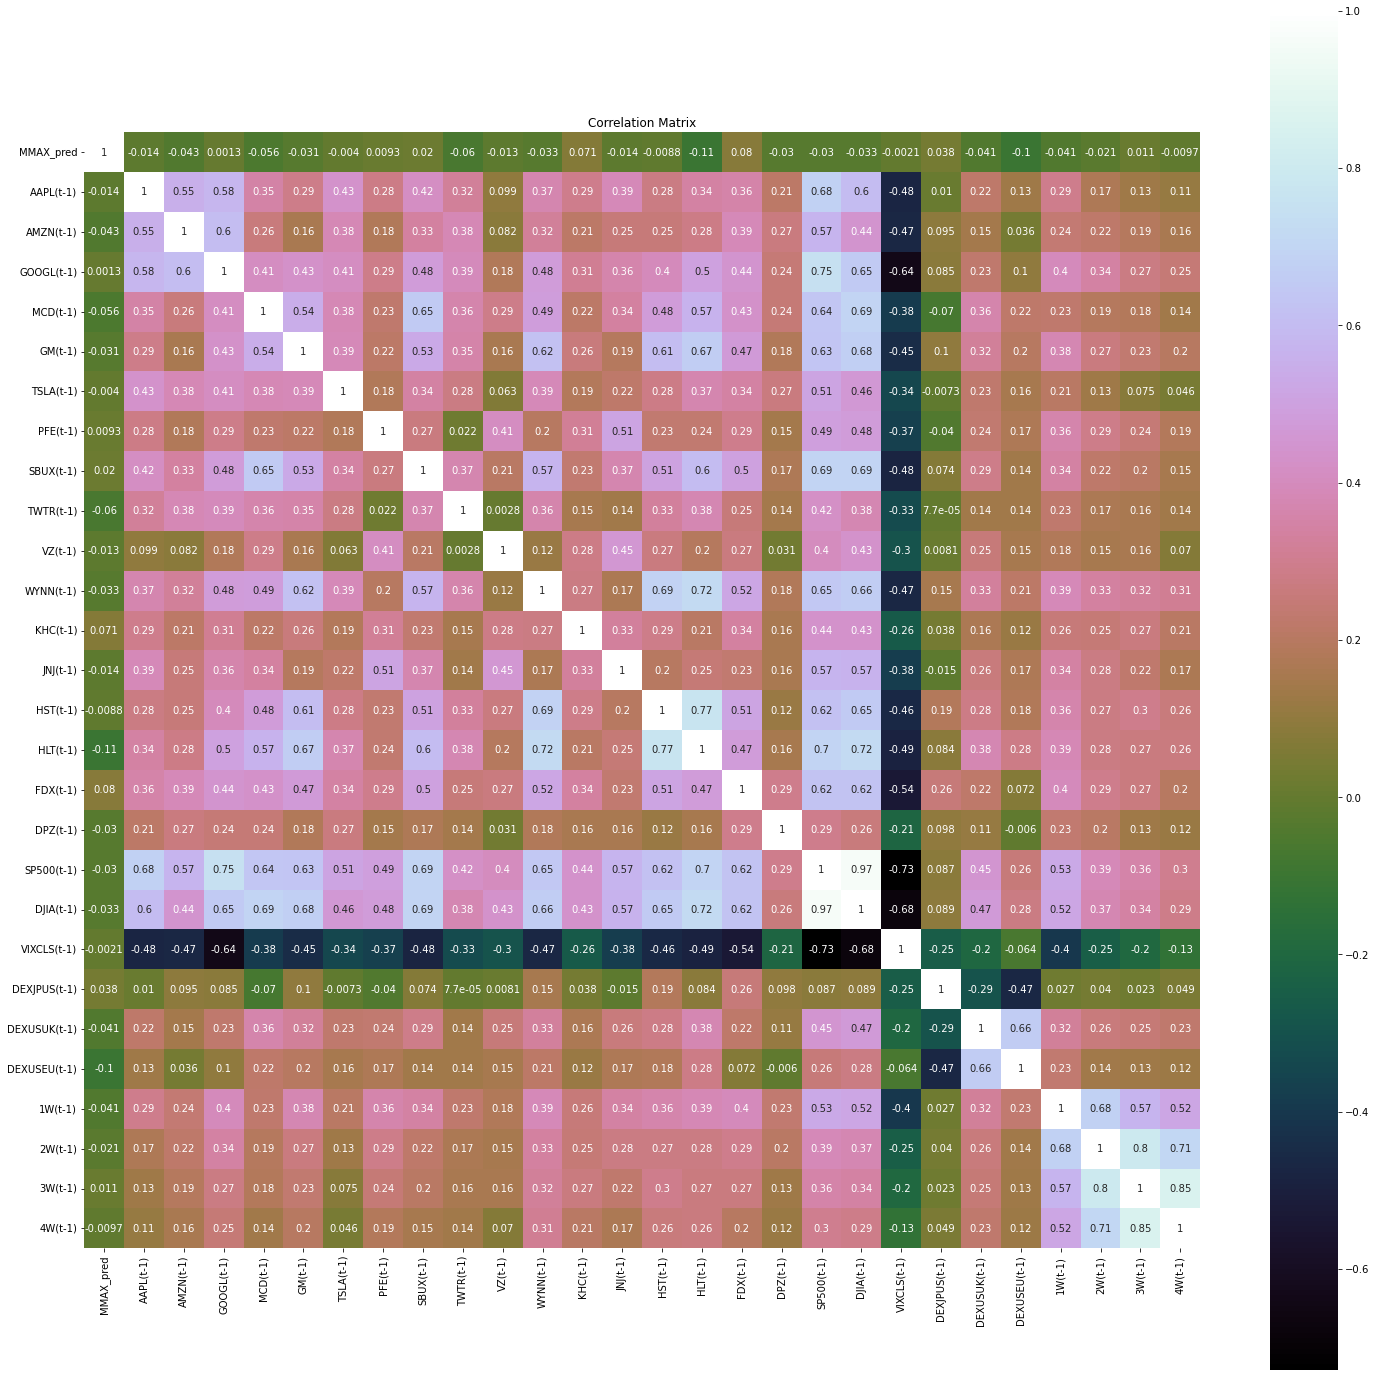

In [30]:
correlation = dataset.corr()
plt.figure(figsize=(25,25))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix');

<Figure size 1080x1080 with 0 Axes>

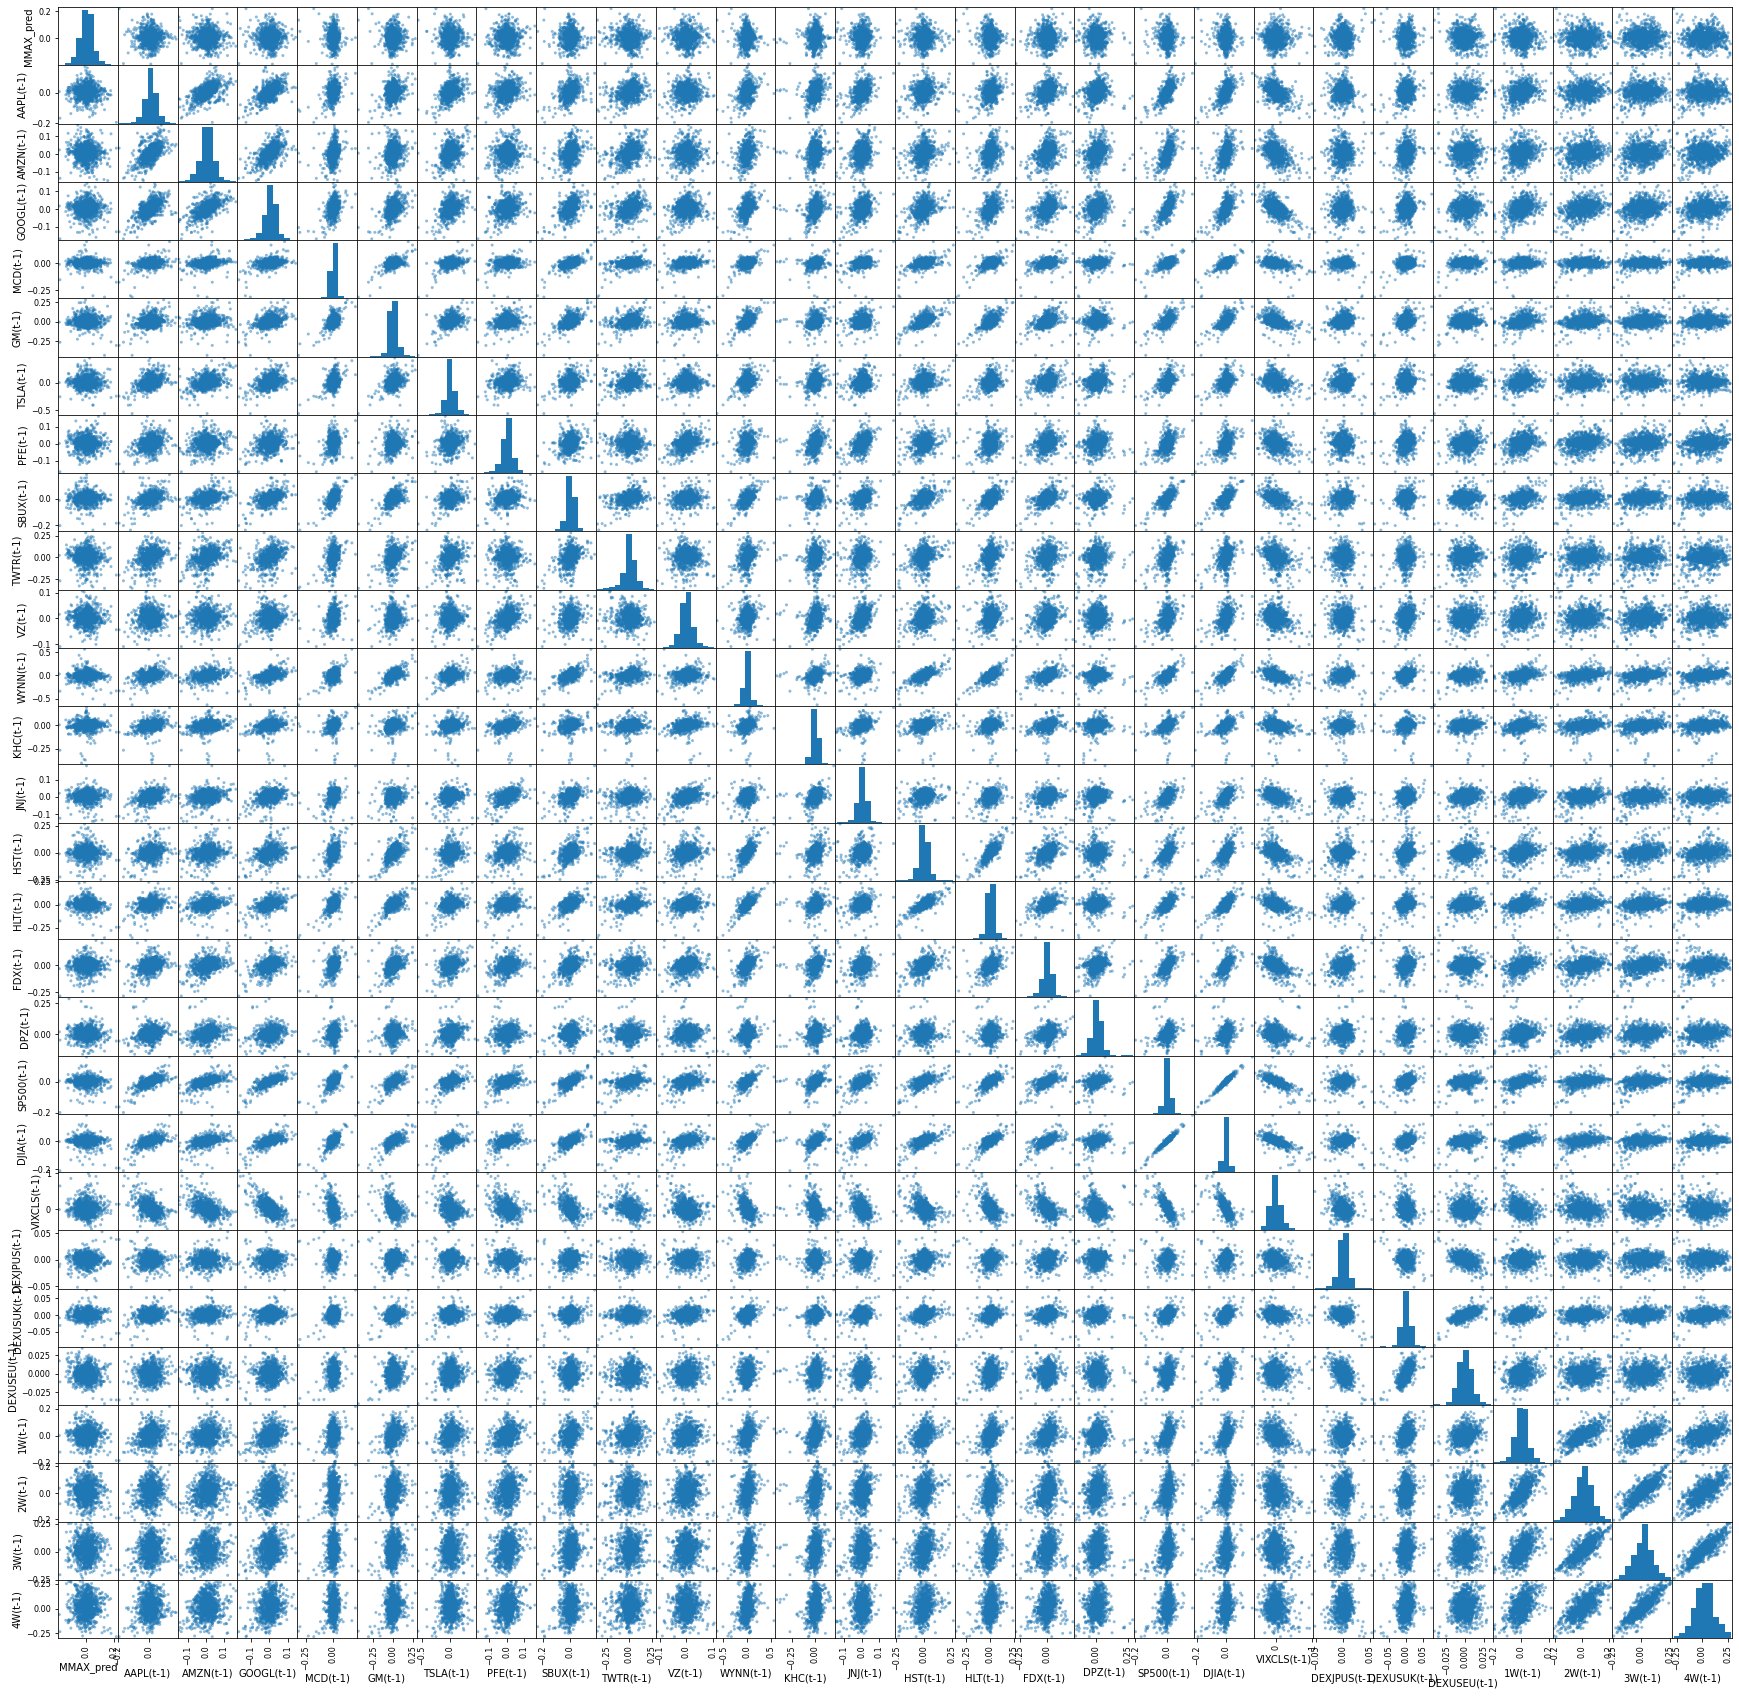

In [31]:
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(30,30))
plt.show();

# Time Series Analysis

C:\Users\Hassan\AppData\Local\Temp/ipykernel_10656/3876745646.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(Y,freq=252)


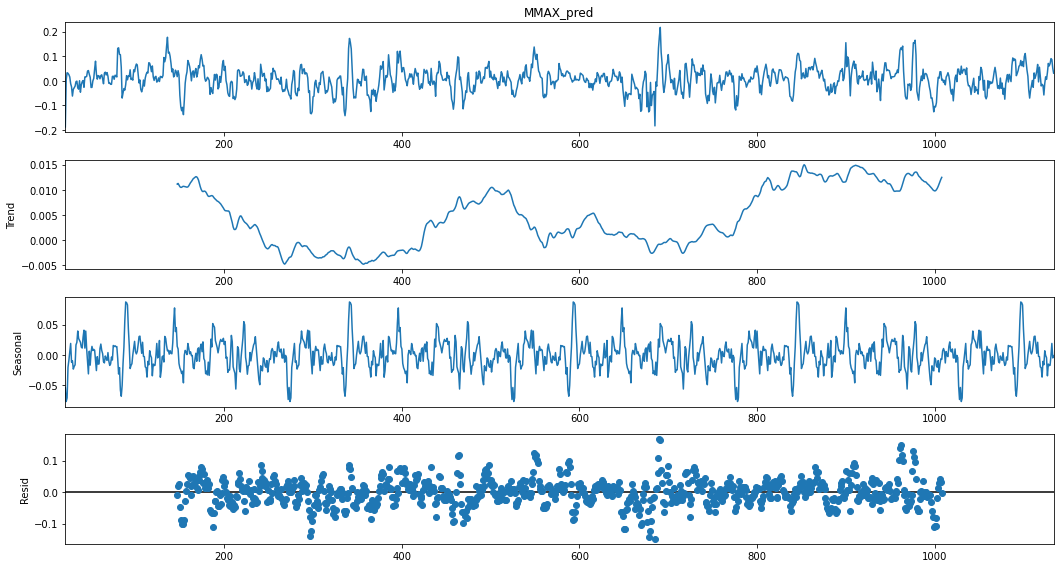

In [32]:
Y= dataset["MMAX_pred"]
res = sm.tsa.seasonal_decompose(Y,freq=252)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show();

# Feature Selection

In [424]:
Y= dataset["MMAX_pred"]
X = dataset.loc[:, dataset.columns != 'MMAX_pred']

In [433]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,  f_regression

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
featureScores.nlargest(28,'Score').set_index('Specs') 

Score
Specs               
HLT(t-1)      12.537
DEXUSEU(t-1)  11.660
FDX(t-1)       7.190
KHC(t-1)       5.684
TWTR(t-1)      4.034
MCD(t-1)       3.547
AMZN(t-1)      2.103
1W(t-1)        1.872
DEXUSUK(t-1)   1.830
DEXJPUS(t-1)   1.591
DJIA(t-1)      1.187
WYNN(t-1)      1.176
GM(t-1)        1.079
SP500(t-1)     1.013
DPZ(t-1)       0.987
2W(t-1)        0.471
SBUX(t-1)      0.460
AAPL(t-1)      0.232
JNJ(t-1)       0.228
VZ(t-1)        0.195
3W(t-1)        0.123
4W(t-1)        0.104
PFE(t-1)       0.097
HST(t-1)       0.086
TSLA(t-1)      0.018
VIXCLS(t-1)    0.005
GOOGL(t-1)     0.002

In [33]:
#Making a copy of the X variable dataset
X1 = X.copy()

In [430]:
#dropping 5 least important variables
X1.drop(columns=['GOOGL(t-1)','VIXCLS(t-1)','TSLA(t-1)','HST(t-1)','PFE(t-1)'], inplace=True)

# Data Split

In [87]:
test_size = 0.2

train_size = int((len(X)) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:(len(X))]
Y_train, Y_test = Y[0:train_size], Y[train_size:(len(X))]

#with 5 least important features removed

X_train1, X_test1 = X1[0:train_size], X1[train_size:(len(X))]

## Algorithms and Ensembles

The below five models were selected for predicting the MMAX stock price:

1) K Nearest Neighbors (KNN)

2) Support Vector Regression (SVR)

3) Random Forest Regressor (RFR)

4) Extra Trees Regressor (ETR)

5) Time Series Analysis – ARIMA

The purpose of selecting this set of models was to have a variety of algorithms. KNN offers proximity and distance-based rules to make predictions. SVR generates complex decision boundary lines (or best fit lines) to make predictions. RFR and ETR use decision trees to make predictions and finally, ARIMA is a statistical model that predicts or forecasts future values on the basis of past trends.

In [437]:
num_folds = 10
scoring = 'neg_mean_squared_error'

models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

#### Running Models with reduced X variables (5 least important variables removed)

In [438]:
seed =17

names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
    cv_results = -1* cross_val_score(model, X_train1, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train1, Y_train)
    train_result = mean_squared_error(res.predict(X_train1), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test1), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)


Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
KNN: 	  0.001630 	  (0.000475) 	   0.000991 	   0.002697
SVR: 	  0.002595 	  (0.000496) 	   0.002292 	   0.002758
RFR: 	  0.001816 	  (0.000425) 	   0.000253 	   0.002440
ETR: 	  0.001578 	  (0.000371) 	   0.000000 	   0.002404


#### Running Models with original total X variables (none removed)

In [439]:
seed =17

names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
KNN: 	  0.001681 	  (0.000397) 	   0.000956 	   0.002572
SVR: 	  0.002497 	  (0.000404) 	   0.002280 	   0.002805
RFR: 	  0.001809 	  (0.000418) 	   0.000245 	   0.002474
ETR: 	  0.001553 	  (0.000352) 	   0.000000 	   0.002465


We can see that apart from KNN, all other models performed better (or in other words yielded lower MSE scores) with the 22 feature dataset.

This allows us to discard the 27 X feature dataset and use the 22 X feature dataset for all further analysis.

## Scaling Data with Features Removed (Multiple Scaling Configuration)

In [440]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X1))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X1)
StandardisedX = pd.DataFrame(scaler.fit_transform(X1))

from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X1)
NormalizedX = pd.DataFrame(scaler.fit_transform(X1))

In [441]:
X_trainMM, X_testMM = rescaledX[0:train_size], rescaledX[train_size:(len(X))]
X_trainSTD, X_testSTD = StandardisedX[0:train_size], StandardisedX[train_size:(len(X))]
X_trainNML, X_testNML = NormalizedX[0:train_size], NormalizedX[train_size:(len(X))]

In [443]:
seed =17

names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    cv_results = -1* cross_val_score(model, X_trainMM, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_trainMM, Y_train)
    train_result = mean_squared_error(res.predict(X_trainMM), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_testMM), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
KNN: 	  0.001579 	  (0.000471) 	   0.000873 	   0.002811
SVR: 	  0.002483 	  (0.000512) 	   0.002173 	   0.002661
RFR: 	  0.001821 	  (0.000413) 	   0.000258 	   0.002470
ETR: 	  0.001589 	  (0.000420) 	   0.000000 	   0.002467


In [444]:
seed =17

names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    cv_results = -1* cross_val_score(model, X_trainSTD, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_trainSTD, Y_train)
    train_result = mean_squared_error(res.predict(X_trainSTD), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_testSTD), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
KNN: 	  0.001523 	  (0.000417) 	   0.000838 	   0.002742
SVR: 	  0.002441 	  (0.000484) 	   0.002145 	   0.002584
RFR: 	  0.001799 	  (0.000423) 	   0.000263 	   0.002439
ETR: 	  0.001575 	  (0.000391) 	   0.000000 	   0.002454


In [445]:
seed =17

names = []
kfold_results = []
test_results = []
train_results = []

print("Model,\t CrossValMean,\t CrossValSTD,\t train_MSE,\t test_MSE")
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
    cv_results = -1* cross_val_score(model, X_trainNML, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_trainNML, Y_train)
    train_result = mean_squared_error(res.predict(X_trainNML), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_testNML), Y_test)
    test_results.append(test_result)
    
    msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

Model,	 CrossValMean,	 CrossValSTD,	 train_MSE,	 test_MSE
KNN: 	  0.001717 	  (0.000473) 	   0.000998 	   0.003172
SVR: 	  0.002520 	  (0.000440) 	   0.002191 	   0.002574
RFR: 	  0.001919 	  (0.000423) 	   0.000271 	   0.002517
ETR: 	  0.001706 	  (0.000413) 	   0.000000 	   0.002459


# Time Series Models

In [446]:
X_train_ARIMA=X_train1
X_test_ARIMA=X_test1
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

In [447]:
X_trainMM_ARIMA=X_trainMM
X_testMM_ARIMA=X_testMM

X_trainSTD_ARIMA=X_trainSTD
X_testSTD_ARIMA=X_testSTD

X_trainNML_ARIMA=X_trainNML
X_testNML_ARIMA=X_testNML

In [448]:
s=np.arange(21,912)

X_trainMM_ARIMA.set_index([pd.Index(s)],inplace=True)
X_trainSTD_ARIMA.set_index([pd.Index(s)],inplace=True)
X_trainNML_ARIMA.set_index([pd.Index(s)],inplace=True)

In [449]:
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)


print('ARIMA test error:\t',error_Test_ARIMA)
print('ARIMA train error:\t',error_Training_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA test error:	 0.0026082109567770514
ARIMA train error:	 0.000978790356370282


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [450]:
modelARIMA=ARIMA(endog=Y_train,exog=X_trainMM_ARIMA,order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_testMM_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)


print('ARIMA test error:\t',error_Test_ARIMA)
print('ARIMA train error:\t',error_Training_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA test error:	 0.0026082109169058535
ARIMA train error:	 0.000978790390790825


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [451]:
modelARIMA=ARIMA(endog=Y_train,exog=X_trainSTD_ARIMA,order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_testSTD_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)


print('ARIMA test error:\t',error_Test_ARIMA)
print('ARIMA train error:\t',error_Training_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA test error:	 0.0026082109772940063
ARIMA train error:	 0.0009787903568196992


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [452]:
modelARIMA=ARIMA(endog=Y_train,exog=X_trainNML_ARIMA,order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_testNML_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)


print('ARIMA test error:\t',error_Test_ARIMA)
print('ARIMA train error:\t',error_Training_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA test error:	 0.0026264488206993513
ARIMA train error:	 0.0009835083838087865


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


These results indicate that:

• KNN performs better on an unscaled dataset

• SVR performs better on a normalized dataset

• RFR performs better on a standardized dataset

• ETR performs better on an unscaled dataset

• ARIMA performs better on a MinMax dataset (very small difference in MSE score)

Having matched the scaling configuration for each model, we can now progress to tune their hyperparameter using their optimizing scaled datasets.
We used Optuna for tuning the hyperparameters of KNN, SVR, RFR and ETR, and GridSearch for ARIMA.

# Hyperparameter Tuning

In [453]:
def objective_KNN(trial,X_train1,Y_train):
    
    hyper_params_KNN = {
        "n_neighbors": trial.suggest_int("n_neighbors",1,101,step=2),
       }
    
    KNN = KNeighborsRegressor(**hyper_params_KNN)
    
    cv_scores_KNN = cross_val_score(KNN,X_train1,Y_train,cv=2,scoring="neg_mean_squared_error")
    score = np.mean(cv_scores_KNN)
    
    return score


In [454]:
study = optuna.create_study(direction="maximize")

[I 2022-08-05 17:13:54,955] A new study created in memory with name: no-name-e9b1a19f-026d-4ad3-bd8b-fc4f3b418b35


In [455]:
study.optimize(lambda trial: objective_KNN(trial, X_train1,Y_train), n_trials=100,  gc_after_trial=True)

[I 2022-08-05 17:13:55,425] Trial 0 finished with value: -0.002660213931808395 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: -0.002660213931808395.
[I 2022-08-05 17:14:07,997] Trial 1 finished with value: -0.002483092202753532 and parameters: {'n_neighbors': 51}. Best is trial 1 with value: -0.002483092202753532.
[I 2022-08-05 17:14:09,408] Trial 2 finished with value: -0.0024503272271103336 and parameters: {'n_neighbors': 83}. Best is trial 2 with value: -0.0024503272271103336.
[I 2022-08-05 17:14:10,684] Trial 3 finished with value: -0.002477987869036826 and parameters: {'n_neighbors': 57}. Best is trial 2 with value: -0.0024503272271103336.
[I 2022-08-05 17:14:11,997] Trial 4 finished with value: -0.0026466007826446434 and parameters: {'n_neighbors': 17}. Best is trial 2 with value: -0.0024503272271103336.
[I 2022-08-05 17:14:13,423] Trial 5 finished with value: -0.0025008199810384883 and parameters: {'n_neighbors': 47}. Best is trial 2 with value: -0.002450327227

[I 2022-08-05 17:15:07,760] Trial 45 finished with value: -0.00244785645908596 and parameters: {'n_neighbors': 79}. Best is trial 29 with value: -0.0024450090397190797.
[I 2022-08-05 17:15:09,104] Trial 46 finished with value: -0.002509675704185958 and parameters: {'n_neighbors': 41}. Best is trial 29 with value: -0.0024450090397190797.
[I 2022-08-05 17:15:10,260] Trial 47 finished with value: -0.0024450090397190797 and parameters: {'n_neighbors': 85}. Best is trial 29 with value: -0.0024450090397190797.
[I 2022-08-05 17:15:11,396] Trial 48 finished with value: -0.002443928544751681 and parameters: {'n_neighbors': 97}. Best is trial 48 with value: -0.002443928544751681.
[I 2022-08-05 17:15:12,673] Trial 49 finished with value: -0.002443928544751681 and parameters: {'n_neighbors': 97}. Best is trial 48 with value: -0.002443928544751681.
[I 2022-08-05 17:15:14,015] Trial 50 finished with value: -0.0024462041213240563 and parameters: {'n_neighbors': 95}. Best is trial 48 with value: -0.00

[I 2022-08-05 17:16:06,194] Trial 90 finished with value: -0.002442442765382885 and parameters: {'n_neighbors': 87}. Best is trial 77 with value: -0.002442442765382885.
[I 2022-08-05 17:16:07,525] Trial 91 finished with value: -0.002442442765382885 and parameters: {'n_neighbors': 87}. Best is trial 77 with value: -0.002442442765382885.
[I 2022-08-05 17:16:08,820] Trial 92 finished with value: -0.002442442765382885 and parameters: {'n_neighbors': 87}. Best is trial 77 with value: -0.002442442765382885.
[I 2022-08-05 17:16:10,198] Trial 93 finished with value: -0.002450848837515689 and parameters: {'n_neighbors': 81}. Best is trial 77 with value: -0.002442442765382885.
[I 2022-08-05 17:16:11,559] Trial 94 finished with value: -0.002442442765382885 and parameters: {'n_neighbors': 87}. Best is trial 77 with value: -0.002442442765382885.
[I 2022-08-05 17:16:12,834] Trial 95 finished with value: -0.0024519545563385444 and parameters: {'n_neighbors': 77}. Best is trial 77 with value: -0.00244

In [456]:
study.best_params

{'n_neighbors': 87}

In [461]:
def objective_SVR(trial,X_trainNML,Y_train):
    
    hyper_params_SVR = {
        "C": trial.suggest_float("C",0.01,1,step=0.01),
        "gamma": trial.suggest_float("gamma",0.001,1,step=0.01)
       }
    
    modelSVR = SVR(**hyper_params_SVR)
    
    cv_scores_SVR = cross_val_score(modelSVR,X_trainNML,Y_train,cv=10,scoring="neg_mean_squared_error")
    score = np.mean(cv_scores_SVR)
    
    return score


In [462]:
study_SVR = optuna.create_study(direction="maximize")

[I 2022-08-05 17:21:17,895] A new study created in memory with name: no-name-dffbccc8-55c7-42c9-adc1-e6e36aafa13b


In [463]:
study_SVR.optimize(lambda trial: objective_SVR(trial, X_trainNML,Y_train), n_trials=100,  gc_after_trial=True)

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:21:18,412] Trial 0 finished with value: -0.0027850548853310016 and parameters: {'C': 0.13, 'gamma': 0.9410000000000001}. Best is trial 0 with value: -0.0027850548853310016.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:21:19,854] Trial 1 finished with value: -0.0032121085196661083 and parameters: {'C': 0.8300000000000001, 'gamma': 0.481}. Best is trial 0 with value: -0.0027850548853310016.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but th

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:21:45,364] Trial 19 finished with value: -0.002875177307898173 and parameters: {'C': 0.3, 'gamma': 0.151}. Best is trial 11 with value: -0.0024267156969735274.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:21:46,820] Trial 20 finished with value: -0.0031942946423491303 and parameters: {'C': 0.46, 'gamma': 0.35100000000000003}. Best is trial 11 with value: -0.0024267156969735274.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:22:12,153] Trial 38 finished with value: -0.002533513511320011 and parameters: {'C': 0.09, 'gamma': 0.061}. Best is trial 30 with value: -0.0024175515293002625.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:22:13,583] Trial 39 finished with value: -0.0028415079075267183 and parameters: {'C': 0.19, 'gamma': 0.221}. Best is trial 30 with value: -0.0024175515293002625.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:22:38,768] Trial 57 finished with value: -0.0026156197435504096 and parameters: {'C': 0.16, 'gamma': 0.081}. Best is trial 30 with value: -0.0024175515293002625.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:22:40,212] Trial 58 finished with value: -0.0024818832664852877 and parameters: {'C': 0.09, 'gamma': 0.031}. Best is trial 30 with value: -0.0024175515293002625.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisibl

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:23:06,164] Trial 76 finished with value: -0.002477899368013911 and parameters: {'C': 0.11, 'gamma': 0.021}. Best is trial 74 with value: -0.0024165974683548496.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:23:07,586] Trial 77 finished with value: -0.0024478952459927013 and parameters: {'C': 0.01, 'gamma': 0.121}. Best is trial 74 with value: -0.0024165974683548496.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:23:33,326] Trial 95 finished with value: -0.0024875132210732823 and parameters: {'C': 0.060000000000000005, 'gamma': 0.051000000000000004}. Best is trial 74 with value: -0.0024165974683548496.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01, but the range is not divisible by `q`. It will be replaced by [0.001, 0.991].
  warnings.warn(
[I 2022-08-05 17:23:34,793] Trial 96 finished with value: -0.0024373274247934435 and parameters: {'C': 0.03, 'gamma': 0.021}. Best is trial 74 with value: -0.0024165974683548496.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.001, 1] and q=0.01

In [464]:
study_SVR.best_params

{'C': 0.03, 'gamma': 0.001}

In [465]:
def objective_RFR(trial,X_trainSTD,Y_train):
    
    hyper_params_RFR = {
        "n_estimators": trial.suggest_int("n_estimators",10,500,step=1),
               }
    
    RFR = RandomForestRegressor(**hyper_params_RFR)
    
    cv_scores_RFR = cross_val_score(RFR,X_trainSTD,Y_train,cv=2,scoring="neg_mean_squared_error")
    score = np.mean(cv_scores_RFR)
    
    return score


In [466]:
study_RFR = optuna.create_study(direction="maximize")

[I 2022-08-05 17:24:19,862] A new study created in memory with name: no-name-4b1ca423-4859-4e70-83be-e2c5b021272f


In [467]:
study_RFR.optimize(lambda trial: objective_RFR(trial,X_trainSTD,Y_train), n_trials=100,  gc_after_trial=True)

[I 2022-08-05 17:24:32,453] Trial 0 finished with value: -0.0027389175575158334 and parameters: {'n_estimators': 360}. Best is trial 0 with value: -0.0027389175575158334.
[I 2022-08-05 17:24:42,353] Trial 1 finished with value: -0.002776104067458327 and parameters: {'n_estimators': 268}. Best is trial 0 with value: -0.0027389175575158334.
[I 2022-08-05 17:24:47,822] Trial 2 finished with value: -0.0027727751087687907 and parameters: {'n_estimators': 131}. Best is trial 0 with value: -0.0027389175575158334.
[I 2022-08-05 17:25:03,681] Trial 3 finished with value: -0.0027354449585782984 and parameters: {'n_estimators': 445}. Best is trial 3 with value: -0.0027354449585782984.
[I 2022-08-05 17:25:17,624] Trial 4 finished with value: -0.0027533962365653016 and parameters: {'n_estimators': 387}. Best is trial 3 with value: -0.0027354449585782984.
[I 2022-08-05 17:25:28,140] Trial 5 finished with value: -0.0027490464703602197 and parameters: {'n_estimators': 286}. Best is trial 3 with value:

[I 2022-08-05 17:33:24,994] Trial 45 finished with value: -0.0027535620586008726 and parameters: {'n_estimators': 266}. Best is trial 43 with value: -0.002707172074912458.
[I 2022-08-05 17:33:36,173] Trial 46 finished with value: -0.002769205349662264 and parameters: {'n_estimators': 299}. Best is trial 43 with value: -0.002707172074912458.
[I 2022-08-05 17:33:48,489] Trial 47 finished with value: -0.0027276755457539903 and parameters: {'n_estimators': 337}. Best is trial 43 with value: -0.002707172074912458.
[I 2022-08-05 17:34:02,661] Trial 48 finished with value: -0.0027580750532484304 and parameters: {'n_estimators': 392}. Best is trial 43 with value: -0.002707172074912458.
[I 2022-08-05 17:34:11,700] Trial 49 finished with value: -0.0027365200442152995 and parameters: {'n_estimators': 241}. Best is trial 43 with value: -0.002707172074912458.
[I 2022-08-05 17:34:23,437] Trial 50 finished with value: -0.0027337557209068655 and parameters: {'n_estimators': 318}. Best is trial 43 with

[I 2022-08-05 17:41:32,925] Trial 90 finished with value: -0.0027485793762427064 and parameters: {'n_estimators': 500}. Best is trial 77 with value: -0.0027033896648263026.
[I 2022-08-05 17:41:40,552] Trial 91 finished with value: -0.0027250637667718923 and parameters: {'n_estimators': 209}. Best is trial 77 with value: -0.0027033896648263026.
[I 2022-08-05 17:41:46,159] Trial 92 finished with value: -0.0027505878494813204 and parameters: {'n_estimators': 129}. Best is trial 77 with value: -0.0027033896648263026.
[I 2022-08-05 17:41:54,358] Trial 93 finished with value: -0.0027403674126208304 and parameters: {'n_estimators': 191}. Best is trial 77 with value: -0.0027033896648263026.
[I 2022-08-05 17:41:59,713] Trial 94 finished with value: -0.0027636533148244647 and parameters: {'n_estimators': 111}. Best is trial 77 with value: -0.0027033896648263026.
[I 2022-08-05 17:42:09,036] Trial 95 finished with value: -0.002763896853335826 and parameters: {'n_estimators': 245}. Best is trial 77

In [468]:
study_RFR.best_params

{'n_estimators': 252}

In [469]:
def objective_ETR(trial,X_train1,Y_train):
    
    hyper_params_ETR = {
        "n_estimators": trial.suggest_int("n_estimators",10,500,step=1),
               }
    
    ETR = ExtraTreesRegressor(**hyper_params_ETR)

    
    cv_scores_ETR = cross_val_score(ETR,X_train1,Y_train,cv=2,scoring="neg_mean_squared_error")
    score = np.mean(cv_scores_ETR)
    
    return score

In [470]:
study_ETR = optuna.create_study(direction="maximize")

[I 2022-08-05 17:42:50,598] A new study created in memory with name: no-name-48fcdb11-dea2-40dc-8dd7-92445f3e6c28


In [471]:
study_ETR.optimize(lambda trial: objective_ETR(trial,X_train1,Y_train), n_trials=100,  gc_after_trial=True)

[I 2022-08-05 17:42:51,867] Trial 0 finished with value: -0.002628414546738652 and parameters: {'n_estimators': 45}. Best is trial 0 with value: -0.002628414546738652.
[I 2022-08-05 17:42:58,237] Trial 1 finished with value: -0.0026241978566749367 and parameters: {'n_estimators': 297}. Best is trial 1 with value: -0.0026241978566749367.
[I 2022-08-05 17:43:03,505] Trial 2 finished with value: -0.0026205551747089362 and parameters: {'n_estimators': 242}. Best is trial 2 with value: -0.0026205551747089362.
[I 2022-08-05 17:43:09,576] Trial 3 finished with value: -0.002611313157289924 and parameters: {'n_estimators': 275}. Best is trial 3 with value: -0.002611313157289924.
[I 2022-08-05 17:43:18,925] Trial 4 finished with value: -0.002607123625280111 and parameters: {'n_estimators': 462}. Best is trial 4 with value: -0.002607123625280111.
[I 2022-08-05 17:43:26,155] Trial 5 finished with value: -0.002615111625835736 and parameters: {'n_estimators': 350}. Best is trial 4 with value: -0.002

[I 2022-08-05 17:48:06,819] Trial 45 finished with value: -0.002637870807502503 and parameters: {'n_estimators': 403}. Best is trial 28 with value: -0.0025901718635675435.
[I 2022-08-05 17:48:13,003] Trial 46 finished with value: -0.00262281161400835 and parameters: {'n_estimators': 340}. Best is trial 28 with value: -0.0025901718635675435.
[I 2022-08-05 17:48:18,716] Trial 47 finished with value: -0.0026086448689602764 and parameters: {'n_estimators': 266}. Best is trial 28 with value: -0.0025901718635675435.
[I 2022-08-05 17:48:27,904] Trial 48 finished with value: -0.002628949293278073 and parameters: {'n_estimators': 464}. Best is trial 28 with value: -0.0025901718635675435.
[I 2022-08-05 17:48:35,802] Trial 49 finished with value: -0.0026129274813614057 and parameters: {'n_estimators': 375}. Best is trial 28 with value: -0.0025901718635675435.
[I 2022-08-05 17:48:44,562] Trial 50 finished with value: -0.002601903046182936 and parameters: {'n_estimators': 419}. Best is trial 28 wit

[I 2022-08-05 17:54:04,664] Trial 90 finished with value: -0.0026031539240629013 and parameters: {'n_estimators': 493}. Best is trial 55 with value: -0.0025846713126147086.
[I 2022-08-05 17:54:13,734] Trial 91 finished with value: -0.0026058428960810376 and parameters: {'n_estimators': 477}. Best is trial 55 with value: -0.0025846713126147086.
[I 2022-08-05 17:54:22,937] Trial 92 finished with value: -0.0026232452042473974 and parameters: {'n_estimators': 486}. Best is trial 55 with value: -0.0025846713126147086.
[I 2022-08-05 17:54:31,712] Trial 93 finished with value: -0.002611188693361586 and parameters: {'n_estimators': 463}. Best is trial 55 with value: -0.0025846713126147086.
[I 2022-08-05 17:54:40,129] Trial 94 finished with value: -0.0026107747921133083 and parameters: {'n_estimators': 442}. Best is trial 55 with value: -0.0025846713126147086.
[I 2022-08-05 17:54:49,135] Trial 95 finished with value: -0.0026080304171026423 and parameters: {'n_estimators': 470}. Best is trial 55

In [472]:
study_ETR.best_params

{'n_estimators': 430}

In [473]:

def evaluate_arima_model(arima_order):
   
    modelARIMA=ARIMA(endog=Y_train,exog=X_trainMM_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()   
    
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 

def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

evaluate_models(p_values, d_values, q_values)   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(0, 0, 0) MSE=0.0022109


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(0, 0, 1) MSE=0.0013164


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(1, 0, 0) MSE=0.0009788


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(1, 0, 1) MSE=0.0009716


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(2, 0, 0) MSE=0.0009678


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA(2, 0, 1) MSE=0.0009361


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

Best ARIMA(2, 0, 1) MSE=0.0009361


# New Scores

In [474]:
seed=17

KNN = KNeighborsRegressor(n_neighbors=87)
    
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
cv_results = -1* cross_val_score(KNN, X_train1, Y_train, cv=kfold, scoring=scoring)
   
res = KNN.fit(X_train1, Y_train)
train_result = mean_squared_error(res.predict(X_train1), Y_train)
      
test_result = mean_squared_error(res.predict(X_test1), Y_test)
    
msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (KNN, cv_results.mean(), cv_results.std(), train_result, test_result)
print(msg)

KNeighborsRegressor(n_neighbors=87): 	  0.002360 	  (0.000500) 	   0.002300 	   0.002487


In [475]:
seed=17

modelSVR = SVR(C=0.03,gamma=0.001)
    
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
cv_results = -1* cross_val_score(modelSVR, X_trainNML, Y_train, cv=kfold, scoring=scoring)
   
res = modelSVR.fit(X_trainNML, Y_train)
train_result = mean_squared_error(res.predict(X_trainNML), Y_train)
      
test_result = mean_squared_error(res.predict(X_testNML), Y_test)
    
msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (modelSVR, cv_results.mean(), cv_results.std(), train_result, test_result)
print(msg)

SVR(C=0.03, gamma=0.001): 	  0.002409 	  (0.000513) 	   0.002396 	   0.002484


In [476]:
seed=17

RFR = RandomForestRegressor(n_estimators=252)
    
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
cv_results = -1* cross_val_score(RFR, X_trainSTD, Y_train, cv=kfold, scoring=scoring)
   
res = RFR.fit(X_trainSTD, Y_train)
train_result = mean_squared_error(res.predict(X_trainSTD), Y_train)
      
test_result = mean_squared_error(res.predict(X_testSTD), Y_test)
    
msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (RFR, cv_results.mean(), cv_results.std(), train_result, test_result)
print(msg)

RandomForestRegressor(n_estimators=252): 	  0.001784 	  (0.000414) 	   0.000247 	   0.002411


In [477]:
seed=17

ETR = ExtraTreesRegressor(n_estimators=430)
    
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
   
cv_results = -1* cross_val_score(ETR, X_train1, Y_train, cv=kfold, scoring=scoring)
   
res = ETR.fit(X_train1, Y_train)
train_result = mean_squared_error(res.predict(X_train1), Y_train)
      
test_result = mean_squared_error(res.predict(X_test1), Y_test)
    
msg = "%s: \t  %f \t  (%f) \t   %f \t   %f" % (ETR, cv_results.mean(), cv_results.std(), train_result, test_result)
print(msg)

ExtraTreesRegressor(n_estimators=430): 	  0.001557 	  (0.000393) 	   0.000000 	   0.002387


In [509]:
modelARIMA=ARIMA(endog=Y_train,exog=X_trainMM_ARIMA,order=[1,0,0])

model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_testMM_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)

print('ARIMA test error:\t',error_Test_ARIMA)
print('ARIMA train error:\t',error_Training_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

ARIMA test error:	 0.0026082109169058535
ARIMA train error:	 0.000978790390790825


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


### From the results, we can see that ETR yielded the lowest MSE score and can be used to predict the missing stock price for MMAX.

# Feature Importance

ExtraTreesRegressor(n_estimators=430)

[0.03184161 0.04662216 0.04257388 0.05282194 0.0529365  0.03684949
 0.04100451 0.04671786 0.04095887 0.03888553 0.04762954 0.03767675
 0.05841397 0.03406679 0.03459357 0.04999245 0.04566055 0.08122126
 0.04059357 0.03482507 0.0392742  0.06483994]


<AxesSubplot:>

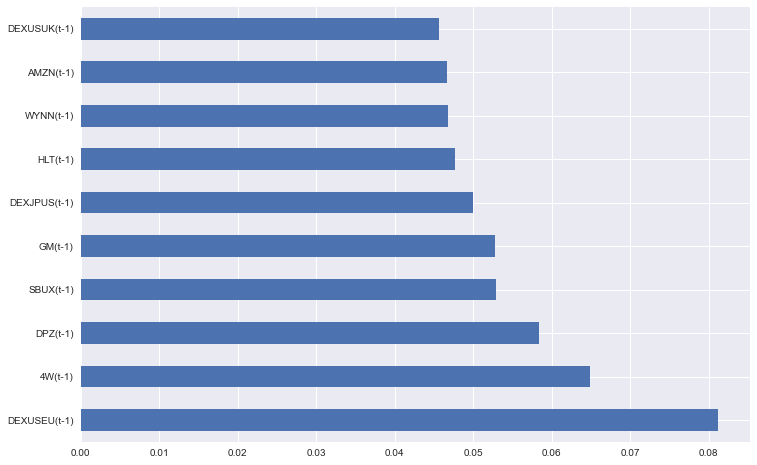

In [602]:
model = ExtraTreesRegressor(n_estimators=430)
model.fit(X_train1,Y_train)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=final_X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Model Selected (Lowest Error) to Predict Missing Price
### ETR with the unscaled dataset

In [481]:
ETR = ExtraTreesRegressor(n_estimators=430)
ETR.fit(X_train1, Y_train)

ExtraTreesRegressor(n_estimators=430)

In [35]:
Xfeat= pd.DataFrame(Xfeatures).transpose()
Xfeat

AAPL      AMZN     GOOGL       MCD        GM      TSLA     PFE  \
1139  0.01447 -0.014087 -0.001466  0.008531  0.035903  0.059145 -0.0195   

          SBUX      TWTR        VZ  ...     SP500      DJIA    VIXCLS  \
1139  0.039482  0.012676 -0.009903  ...  0.017344  0.017857 -0.072334   

       DEXJPUS   DEXUSUK  DEXUSEU        1W        2W        3W        4W  
1139  0.008283  0.011548 -0.00053  0.030972  0.091473  0.080343  0.098096  

[1 rows x 27 columns]

In [501]:
Xfeat.drop(columns=['GOOGL','VIXCLS','TSLA','HST','PFE'],inplace=True)
Xfeat

AAPL   AMZN    MCD     GM   SBUX   TWTR    VZ   WYNN    KHC    JNJ  ...    DPZ  SP500  \
1139  0.014 -0.014  0.009  0.036  0.039  0.013 -0.01  0.003  0.016  0.026  ...  0.041  0.017   

       DJIA  DEXJPUS  DEXUSUK    DEXUSEU     1W     2W    3W     4W  
1139  0.018    0.008    0.012 -5.300e-04  0.031  0.091  0.08  0.098  

[1 rows x 22 columns]

In [503]:
logreturn=ETR.predict(Xfeat)
logreturn

array([0.0241586])

In [504]:
import math
math.exp(logreturn)

1.0244527859295265

In [505]:
last_return_price=df.iloc[1135,1]

In [603]:
Price_prediction = last_return_price*math.exp(logreturn)
print(Price_prediction)

113.29739530585279


## **Confidence in the Price Prediction**

Apart from the low MSE score of the ETR algorithm, we can see that the positive return on MMAX represented by the increase in the price of the stock on the missing date (day 1,141) is in sync with the important features highlighted by the algorithm – the top features or stocks (DPZ, SBUX, GM) that had high importance as per ETR also recorded positive returns on the missing date as shown below:

In [616]:
dataset.iloc[1140:,5:20]

GM  TSLA    PFE  SBUX   TWTR     VZ   WYNN    KHC    JNJ    HST    HLT    FDX    DPZ  \
1140  0.03 -0.01  0.006  0.04 -0.022 -0.014 -0.044  0.018  0.017  0.002  0.008  0.019  0.033   

      SP500   DJIA  
1140  0.009  0.011